<h1 style="text-align: center;">T-DEV-810</h1>


# Sommaire
- [Introduction](#introduction)
- [Chargement des données](#chargement-des-donnees)
- [Entraînement](#entrainement)
  - [Dataset brut](#dataset-brut)
  - [Dataset augmenté](#dataset-augmente)


# Introduction

    Dans le domaine médical, l’analyse d’images joue un rôle crucial dans le diagnostic précoce et précis de nombreuses pathologies. La radiographie thoracique est notamment un outil fondamental pour l’identification de maladies pulmonaires telles que la pneumonie. Cependant, l’interprétation de ces images peut s’avérer complexe, dépendante de l’expertise du praticien et sujette à des erreurs humaines. C’est dans ce contexte que l’intelligence artificielle, et plus particulièrement l’apprentissage profond, offre des perspectives prometteuses.

    Ce projet a pour objectif de développer un modèle de reconnaissance d’image basé sur un réseau de neurones convolutifs (CNN), capable de détecter automatiquement des signes de pneumonie sur des radiographies pulmonaires. En s’appuyant sur des jeux de données médicaux étiquetés, le modèle sera entraîné à identifier les caractéristiques visuelles typiques de cette pathologie, dans le but d’assister le personnel médical dans leur diagnostic et d'améliorer la rapidité et la fiabilité de la détection.

# Chargement des données

#### Import

In [34]:
import os
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import datasets, layers, models, Sequential, Input

#### Vérification des fichiers du dataset

In [2]:
def verifier_extensions(dossier):
    extensions = set()
    for nom_fichier in os.listdir(dossier):
        if nom_fichier == '.DS_Store':
            continue # exclusion du fichier .DS_Store
        
        chemin_complet = os.path.join(dossier, nom_fichier)
        if os.path.isfile(chemin_complet):
            _, ext = os.path.splitext(nom_fichier)
            extensions.add(ext.lower())
    
    if len(extensions) == 1:
        print(f"Toutes les images dans {dossier} ont la même extension : {extensions.pop()}")
    else:
        print(f"Les extensions trouvées dans {dossier} sont : {extensions}")

# vérification sur tout les repertoires du dataset

verifier_extensions("chest_Xray/val/PNEUMONIA")
verifier_extensions("chest_Xray/val/NORMAL")
verifier_extensions("chest_Xray/test/PNEUMONIA")
verifier_extensions("chest_Xray/test/NORMAL")
verifier_extensions("chest_Xray/train/PNEUMONIA")
verifier_extensions("chest_Xray/train/NORMAL")

Toutes les images dans chest_Xray/val/PNEUMONIA ont la même extension : .jpeg
Toutes les images dans chest_Xray/val/NORMAL ont la même extension : .jpeg
Toutes les images dans chest_Xray/test/PNEUMONIA ont la même extension : .jpeg
Toutes les images dans chest_Xray/test/NORMAL ont la même extension : .jpeg
Toutes les images dans chest_Xray/train/PNEUMONIA ont la même extension : .jpeg
Toutes les images dans chest_Xray/train/NORMAL ont la même extension : .jpeg


#### Statistiques sur la taille des images

In [4]:
# Liste des dossiers à analyser
dossiers_images = [
    "chest_Xray/train/NORMAL",
    "chest_Xray/train/PNEUMONIA",
]

dimensions = []

# Parcourir des dossiers
for dossier in dossiers_images:
    for nom_fichier in os.listdir(dossier):
        chemin_fichier = os.path.join(dossier, nom_fichier)


        if os.path.isfile(chemin_fichier) and nom_fichier.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            try:
                with Image.open(chemin_fichier) as img:
                    dimensions.append(img.size)
            except Exception as e:
                print(f"Erreur avec l'image {nom_fichier} dans {dossier}: {e}")

if dimensions:
    largeurs = [dim[0] for dim in dimensions]
    hauteurs = [dim[1] for dim in dimensions]

    largeur_min = min(largeurs)
    largeur_max = max(largeurs)
    hauteur_min = min(hauteurs)
    hauteur_max = max(hauteurs)

    largeur_moyenne = sum(largeurs) / len(largeurs)
    hauteur_moyenne = sum(hauteurs) / len(hauteurs)

    print(f"Largeur min: {largeur_min}")
    print(f"Largeur max: {largeur_max}")
    print(f"Hauteur min: {hauteur_min}")
    print(f"Hauteur max: {hauteur_max}")
    print(f"Largeur moyenne: {largeur_moyenne:.2f}")
    print(f"Hauteur moyenne: {hauteur_moyenne:.2f}")
else:
    print("Aucune image trouvée dans les dossiers.")


Largeur min: 384
Largeur max: 2916
Hauteur min: 127
Hauteur max: 2663
Largeur moyenne: 1320.61
Hauteur moyenne: 968.07


In [5]:
img_size = (224, 224)
batch_size = 32

# Chargement des datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    "chest_Xray/train",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "chest_Xray/val",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "chest_Xray/test",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [6]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


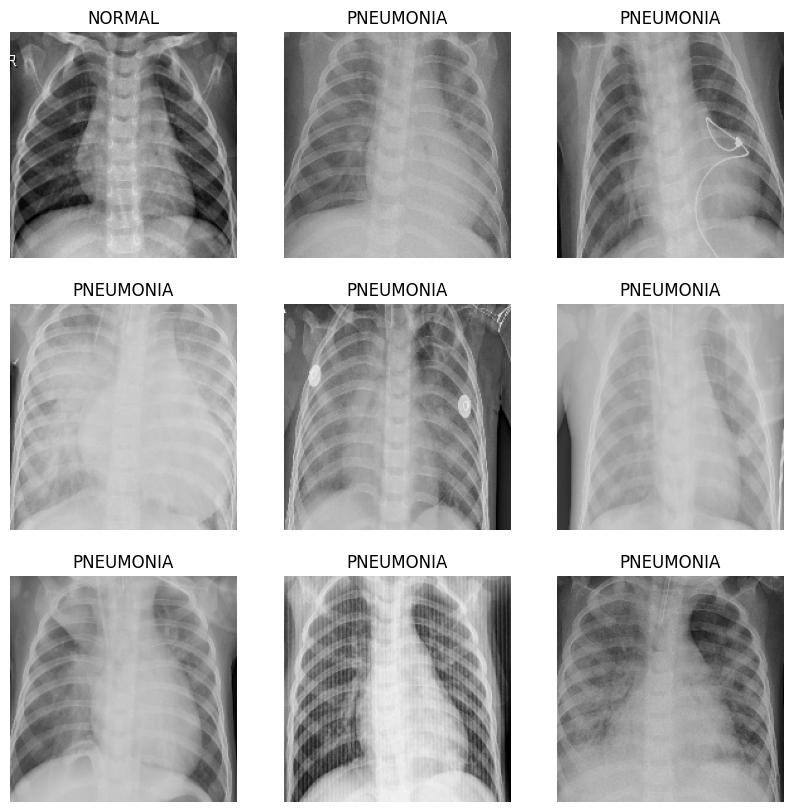

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    cropped_img = tf.image.central_crop(images[i], central_fraction=0.8)
    plt.imshow(cropped_img.numpy().astype("uint8"))
    class_index = tf.argmax(labels[i]).numpy()
    plt.title(class_names[class_index])
    plt.axis("off")


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Entraînement

### Dataset brut

# dernier test

In [9]:
# Modèle intermédiaire de prétraitement
preprocess_model = models.Sequential([
    layers.Lambda(lambda x: tf.image.central_crop(x, central_fraction=0.8)),
    layers.Resizing(224, 224),
    layers.Rescaling(1./255),
])

In [10]:
num_classes = 2

model = models.Sequential([
    preprocess_model,
    layers.Conv2D(128, 4, activation='relu'), # filtre de type kernel (matrice qui met en valeur certaine caractéristique de l'image : lignes verticales ou horizontales)
    layers.MaxPooling2D(), # reduction de la taille de l'info par un facteur 2
    layers.Conv2D(64, 4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [11]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
logdir = "logs"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, write_images=logdir)

In [13]:
model.fit(train_ds, validation_data=test_ds, epochs=5, callbacks=[tensorboard_callback])

Epoch 1/5

163/163 ━━━━━━━━━━━━━━━━━━━━ 552s 3s/step - accuracy: 0.8078 - loss: 0.4613 - val_accuracy: 0.7740 - val_loss: 0.5943
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 528s 3s/step - accuracy: 0.9302 - loss: 0.1864 - val_accuracy: 0.7516 - val_loss: 0.7567
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 530s 3s/step - accuracy: 0.9394 - loss: 0.1505 - val_accuracy: 0.7356 - val_loss: 1.1189
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 498s 3s/step - accuracy: 0.9420 - loss: 0.1429 - val_accuracy: 0.6522 - val_loss: 3.3530
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 530s 3s/step - accuracy: 0.9442 - loss: 0.1552 - val_accuracy: 0.6811 - val_loss: 1.3842


In [19]:
model.export('my_model')

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


Saved artifact at 'my_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  2425464329360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2425464330512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2425464330320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2425464331856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2425464332432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2425464333392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2425464333008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2425464334160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2425464333776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2425464334928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2425464334736: TensorSpec(shape=(), dtype=

In [35]:
# model = models.Sequential([
#     Input(shape=(224, 224, 3)),
#     tf.keras.layers.TFSMLayer('my_model'),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(2, activation='softmax')
# ])

In [36]:
# model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

In [37]:
model.evaluate(val_ds, verbose=2)

AttributeError: 'UninitializedVariable' object has no attribute 'regularizer'

In [14]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 221, 221, 128)       │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 107, 107, 64)        │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 53, 53, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 50, 50, 32)          │          32,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 16)          │           8,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 11, 11, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1936)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         123,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 907,544 (3.46 MB)

 Trainable params: 302,514 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 605,030 (2.31 MB)

In [28]:
conf_dict = {"true_positive": 0, "false_positive": 0, "true_negative": 0, "false_negative": 0}

for images, labels in val_ds.take(1):  # Prend 1 batch
    predictions = model.predict(images)
    scores = tf.nn.softmax(predictions)

    for i in range(len(images)):
        predicted_class = class_names[np.argmax(scores[i])]
        confidence = 100 * np.max(scores[i])
        true_class = class_names[np.argmax(labels[i])]

        if (predicted_class.strip()=='NORMAL' and true_class.strip()=='NORMAL'):
            conf_dict['true_negative'] += 1
        elif (predicted_class.strip()=='NORMAL' and true_class.strip()=='PNEUMONIA'):
            conf_dict['false_negative'] += 1
        elif (predicted_class.strip()=='PNEUMONIA' and true_class.strip()=='NORMAL'):
            conf_dict['false_positive'] += 1
        elif (predicted_class.strip()=='PNEUMONIA' and true_class.strip()=='PNEUMONIA'):
            conf_dict['true_positive'] += 1
        
        print(f"Image {i+1}: Predicted = {predicted_class} ({confidence:.2f}%) | True = {true_class}")

print("------------------------------------------------------------") 

# Matrice de confusion : [[TN, FP], [FN, TP]]
conf_matrix = np.array([
    [conf_dict['true_negative'], conf_dict['false_positive']],
    [conf_dict['false_negative'], conf_dict['true_positive']]
])

fig, ax = plt.subplots()
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)

for (i, j), val in np.ndenumerate(conf_matrix):
    ax.text(j, i, f'{val}', va='center', ha='center', fontsize=14)

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Pred N', 'Pred P'])
ax.set_yticklabels(['Actual N', 'Actual P'])
ax.set_xlabel('Prédiction')
ax.set_ylabel('Réel')
plt.title('Matrice de confusion')
plt.colorbar(cax)
plt.show()
        


KeyError: -1

In [16]:
import math

def compute_metrics(conf_matrix):
    TP = conf_matrix.get("true_positive", 0)
    FP = conf_matrix.get("false_positive", 0)
    TN = conf_matrix.get("true_negative", 0)
    FN = conf_matrix.get("false_negative", 0)

    total = TP + TN + FP + FN

    accuracy = (TP + TN) / total if total else 0
    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0
    specificity = TN / (TN + FP) if (TN + FP) else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) else 0

    mcc_numerator = (TP * TN) - (FP * FN)
    mcc_denominator = math.sqrt((TP + FP)*(TP + FN)*(TN + FP)*(TN + FN))
    mcc = mcc_numerator / mcc_denominator if mcc_denominator else 0

    return {
        "Accuracy": round(accuracy, 3),
        "Precision": round(precision, 3),
        "Recall (Sensitivity)": round(recall, 3),
        "Specificity": round(specificity, 3),
        "F1 Score": round(f1_score, 3),
        "MCC": round(mcc, 3)
    }

metrics = compute_metrics(conf_dict)
for k, v in metrics.items():
    print(f"{k}: {v}")

Accuracy: 0.75
Precision: 0.7
Recall (Sensitivity): 0.875
Specificity: 0.625
F1 Score: 0.778
MCC: 0.516


Le recall est le pourcentage de vrais pneumonies détectées. Dans un contexte médical, ce taux doit absoluement être le plus proche de 100%. Dans notre set de validation, il y a seulement 8 cas de pneumonie, et avec un recall à 86%, cela signifie que une seule pneumonie n'a pas été détectée. Il faudrait plus de données de validation pour affiner cette métrique, et améliorer le modèle en conséquence.

### Dataset augmenté